In [2]:
# 📦 1. Setup & Imports
!pip install -q torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import cv2


In [ ]:
# 📚 2. Define Bottleneck and MiniResNet
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, mid_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, mid_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(mid_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class MiniResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(MiniResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, 1)
        self.layer2 = self._make_layer(block, 128, 1, stride=2)
        self.layer3 = self._make_layer(block, 256, 1, stride=2)
        self.layer4 = self._make_layer(block, 512, 1, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, mid_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != mid_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, mid_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(mid_channels * block.expansion),
            )
        layers = [block(self.in_channels, mid_channels, stride, downsample)]
        self.in_channels = mid_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, mid_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


In [ ]:
# 🧠 Initialize Model
model = MiniResNet(Bottleneck).to('cuda' if torch.cuda.is_available() else 'cpu')
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# 🧼 3. Data Preparation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


In [ ]:
# 🧪 4. Training + Evaluation
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(model.fc.weight.device), y.to(model.fc.weight.device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return total_loss / total, 100 * correct / total


In [ ]:
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
best_acc = 0.0

In [ ]:
for epoch in range(2):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(model.fc.weight.device), y.to(model.fc.weight.device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    scheduler.step()
    train_loss = running_loss / total
    train_acc = 100 * correct / total
    val_loss, val_acc = evaluate_model(model, test_loader)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_miniresnet.pth')
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)
    print(f"Epoch {epoch+1}: Train Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}%")

Epoch 1: Train Acc 41.51% | Val Acc 47.05%
Epoch 2: Train Acc 56.20% | Val Acc 56.97%


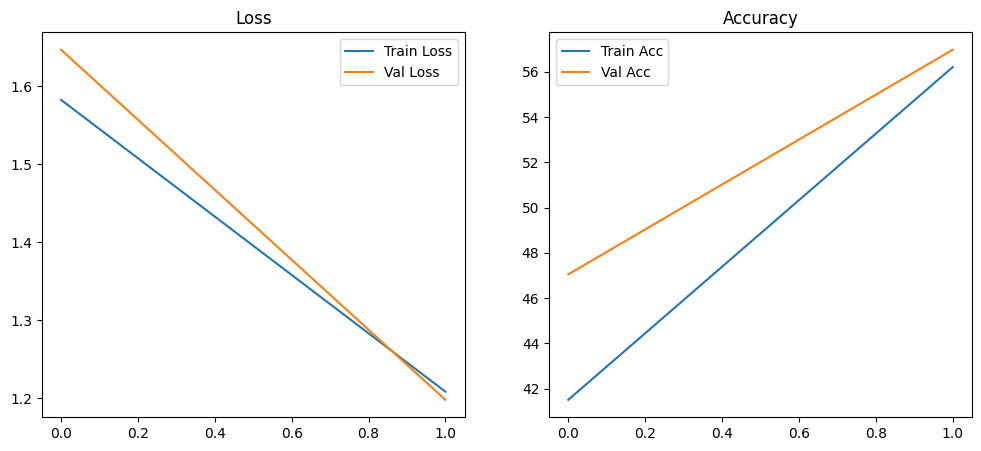

In [ ]:
# 📈 5. Plot Metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.legend(); plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [ ]:
def generate_gradcam(model, image_tensor, target_class, target_layer):
    model.eval()
    gradients, activations = [], []

    def save_gradient(grad):
        gradients.append(grad)

    def forward_hook(module, input, output):
        output.requires_grad_(True)  # ✅ Enable gradients
        activations.append(output)
        output.register_hook(save_gradient)

    hook = target_layer.register_forward_hook(forward_hook)

    output = model(image_tensor.unsqueeze(0))
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    grads = gradients[0].squeeze(0).cpu().detach().numpy()
    acts = activations[0].squeeze(0).cpu().detach().numpy()
    weights = np.mean(grads, axis=(1, 2))
    cam = np.sum(weights[:, None, None] * acts, axis=0)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= cam.min()
    cam /= cam.max()
    hook.remove()
    return cam


In [ ]:
def show_gradcam(image_tensor, cam):
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
    img = np.clip(img, 0, 1)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap / 255.0
    overlay = 0.5 * heatmap + 0.5 * img
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1); plt.imshow(img); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(overlay); plt.title("Grad-CAM"); plt.axis('off')
    plt.show()

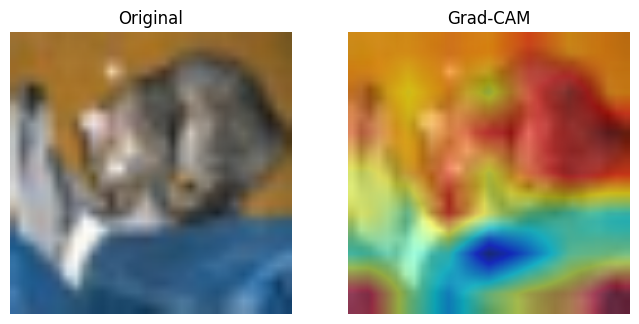

In [ ]:
# 📊 Run Grad-CAM on a test image
image, label = test_dataset[0]
image = image.to(model.fc.weight.device)
model.load_state_dict(torch.load('best_miniresnet.pth'))
model.eval()
pred = model(image.unsqueeze(0)).argmax(1).item()
cam = generate_gradcam(model, image, pred, model.layer4[-1].conv3)
show_gradcam(image, cam)

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch.nn.functional as F

# 🔍 CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def predict_image(model, image_tensor, class_names=class_names):
    model.eval()
    device = model.fc.weight.device
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
    outputs = model(image_tensor)
    probs = F.softmax(outputs, dim=1)
    confidence, predicted = torch.max(probs, 1)
    return class_names[predicted.item()], confidence.item() * 100, predicted.item()

# 🎨 Display 4 predictions with smart styling
def show_four_predictions(model, dataset, class_names=class_names):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle("Model Predictions vs Ground Truth", fontsize=16, weight='bold')

    for ax in axes.flatten():
        idx = random.randint(0, len(dataset) - 1)
        image, true_label = dataset[idx]
        predicted_class, confidence, pred_idx = predict_image(model, image, class_names)

        # Unnormalize
        image_np = image.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)

        # Determine if prediction was correct
        is_correct = pred_idx == true_label
        title_color = 'green' if is_correct else 'red'
        actual = class_names[true_label]
        ax.imshow(image_np)
        ax.set_title(f"{predicted_class} ({confidence:.1f}%)\n[Label: {actual}]",
                     color=title_color, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Leave space for suptitle
    plt.show()


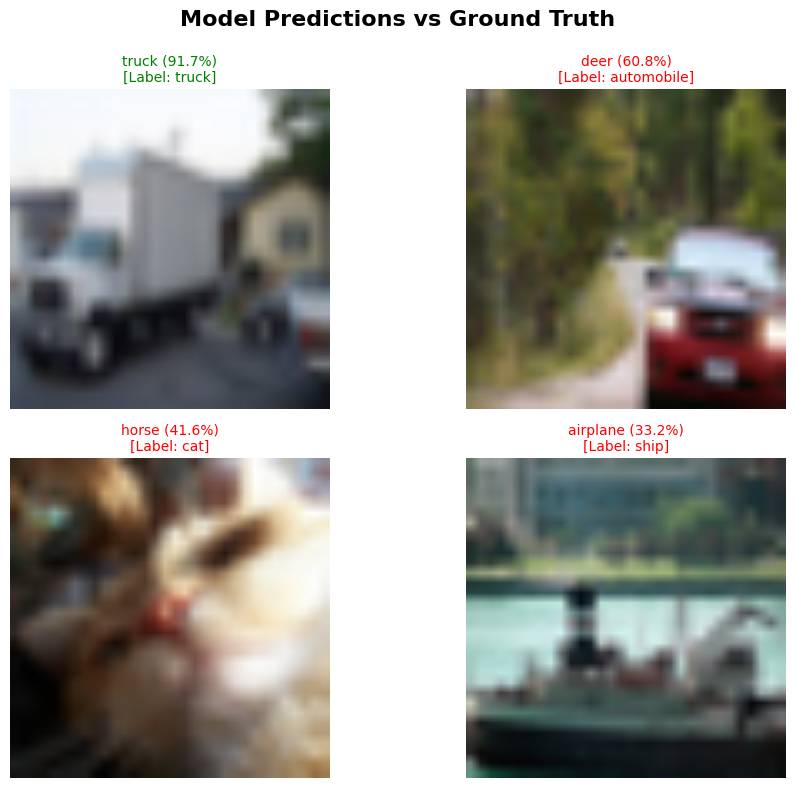

In [ ]:
show_four_predictions(model, test_dataset)

In [91]:
import torch

def save_model_checkpoint(model, optimizer, epoch, loss, path="mini_resnet_checkpoint.pth"):
    """
    Saves the model's state dict, optimizer state, and other training info.

    Args:
        model (nn.Module): Trained model.
        optimizer (torch.optim.Optimizer): Optimizer used in training.
        epoch (int): Final epoch number.
        loss (float): Final training or validation loss.
        path (str): File path to save the checkpoint.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }
    torch.save(checkpoint, path)
    print(f"✅ Model checkpoint saved to: {path}")


In [93]:
# Suppose final_epoch and final_val_loss are known
save_model_checkpoint(model, optimizer, epoch=30, loss=val_loss)

✅ Model checkpoint saved to: mini_resnet_checkpoint.pth


In [94]:
def load_model_checkpoint(model, optimizer, path="mini_resnet_checkpoint.pth"):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"✅ Loaded model from {path} (epoch {epoch}, loss {loss:.4f})")
    return model, optimizer, epoch, loss


In [96]:
# 🔁 Re-initialize model and optimizer
model = MiniResNet(Bottleneck).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 🔓 Load checkpoint
model, optimizer, resumed_epoch, resumed_loss = load_model_checkpoint(model, optimizer)


✅ Loaded model from mini_resnet_checkpoint.pth (epoch 30, loss 1.1976)
